# Rapport

### Innledning

I denne rapporten vurderer vi hvordan vi kan bruke Python og Pythons relevante maskinlærings-biblioteker til å lage maskinærings-modeller som predikerer elevers eksamenskarakterer.

Vi starter med å lese og tolke dataene. For enkelthets skyld, har vi valgt å bare bruke datasettet med elevenes portugisisk-karakterer, ikke datasettet med elevenes matte-karakterer. Vi valgte datasettet med portugisisk-karakterene fordi dette er størst. Videre forbereder vi dataene, før vi lager tre forskjellige modeller. Forskjellen mellom modellene er hvilke forklaringsvariabler de bruker. Til slutt sammenligner vi de tre modellene og plotter noen av egenskapene deres.

In [1]:
#Importering av relevante Python-bibliotek
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import r2_score
import xgboost as xgb
import warnings

#Visningsinstillinger
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### Lesing og tolking av dataene

Vi starter med å lese og tolke dataene. Vi ser at vi har 649 rader og 33 kolonner, altså har vi 649 elever og 33 variabler for hver elev. G3 er eksamenskarakteren vi vil predikere, mens de 32 andre variablene er forklaringsvariabler. 

Videre plotter vi alle forklaringsvariablene mot G3, som scatterplot. Vi ser blant annet at det er en positiv lineær sammenheng mellom både G1 og G3 og G2 og G3. Vi ser også at det er en negativ lineær sammenheng mellom absences og G3. Vi plotter til slutt alle forklaringsvariablene mot hverandre, samt hver av forklaringsvariablenes fordeling (langs diagonalen). Her ser vi blant annet at alle karakterene G1, G2 og G3, er normalfordelte, mens absences er eksponentielt fordelt. 

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \


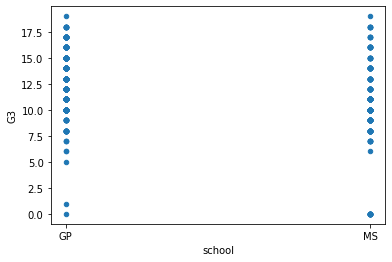

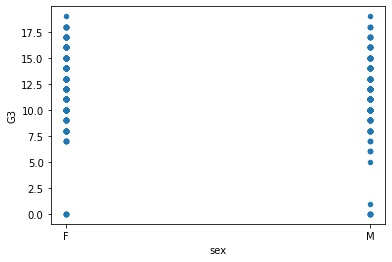

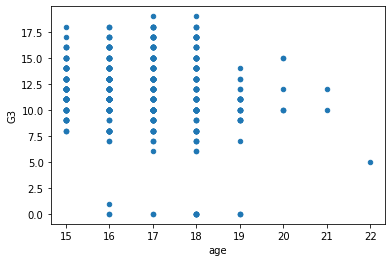

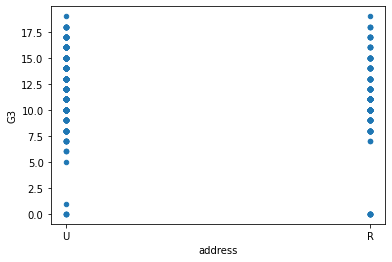

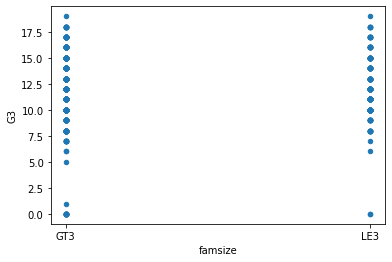

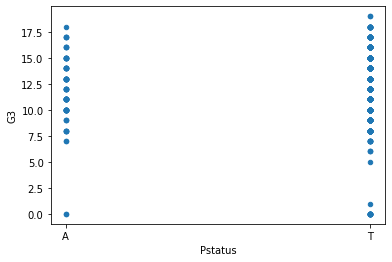

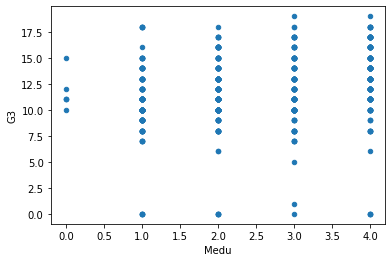

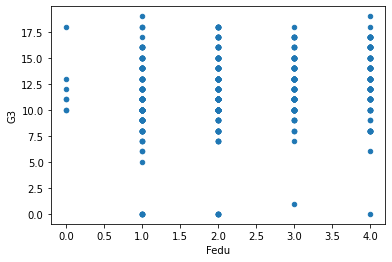

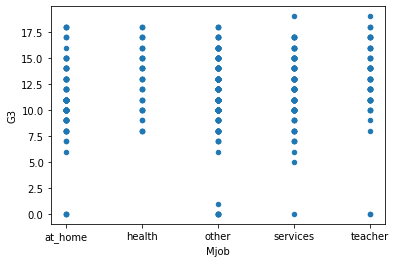

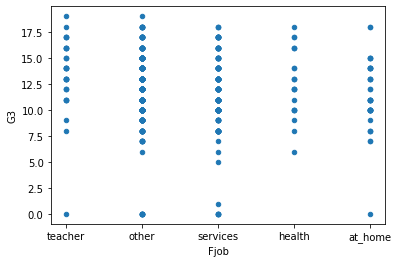

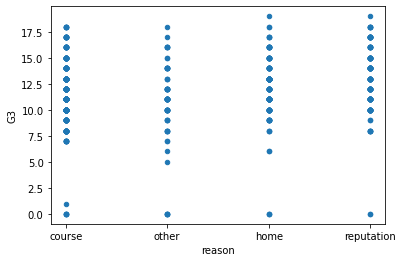

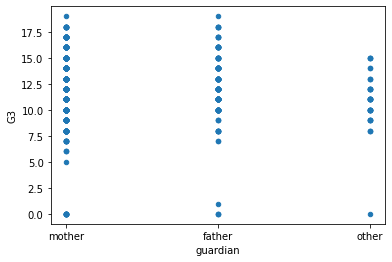

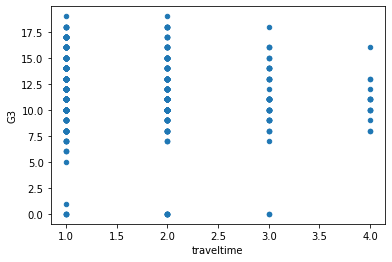

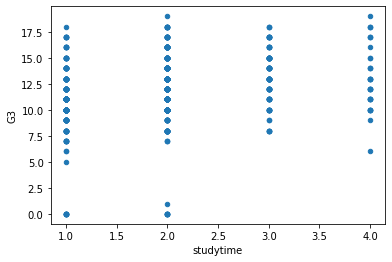

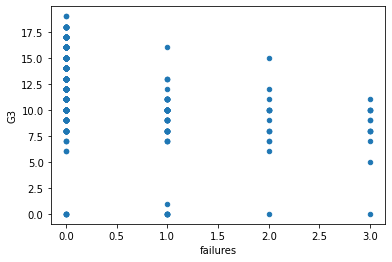

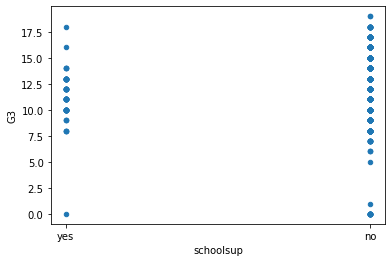

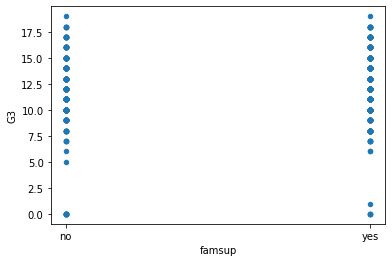

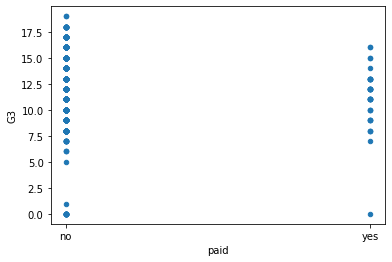

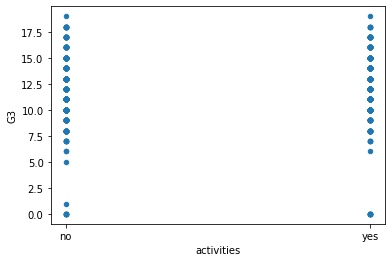

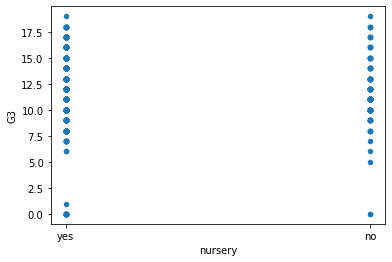

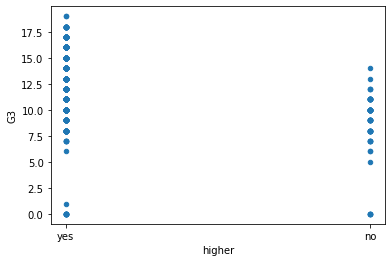

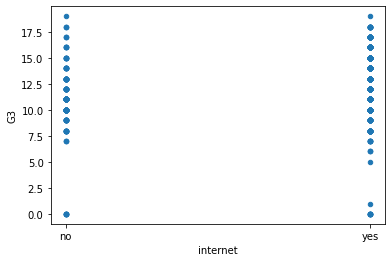

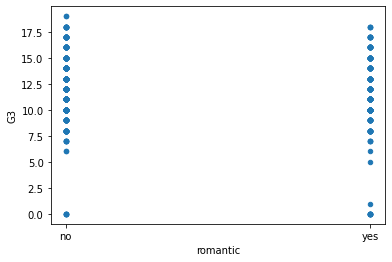

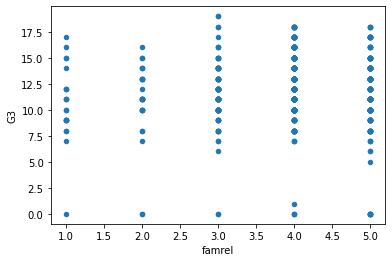

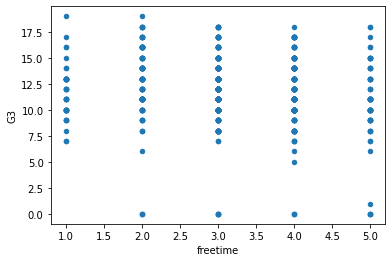

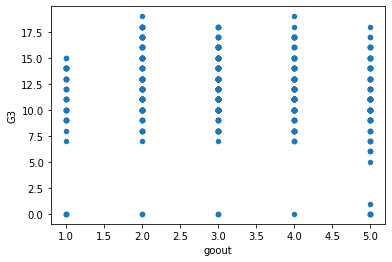

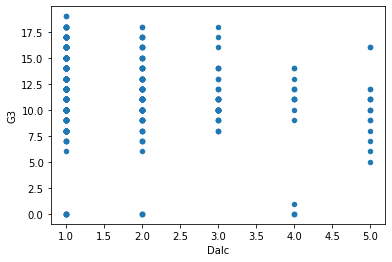

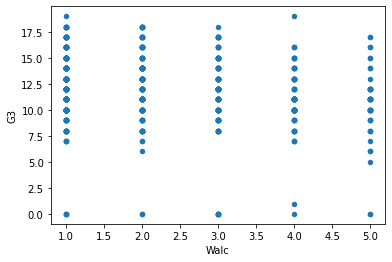

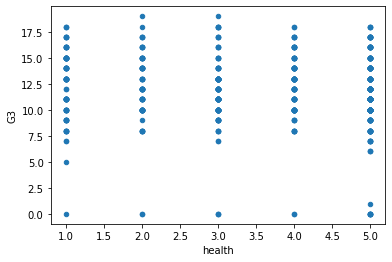

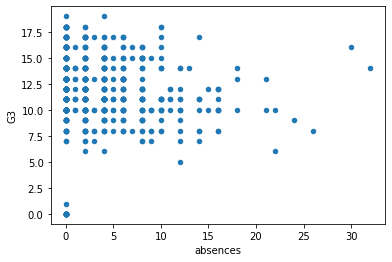

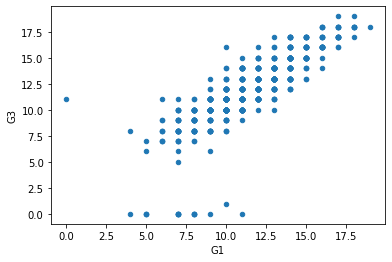

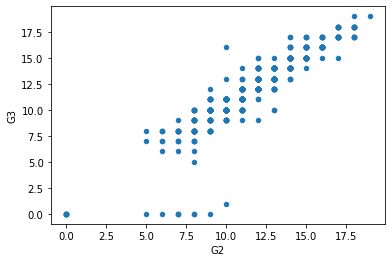

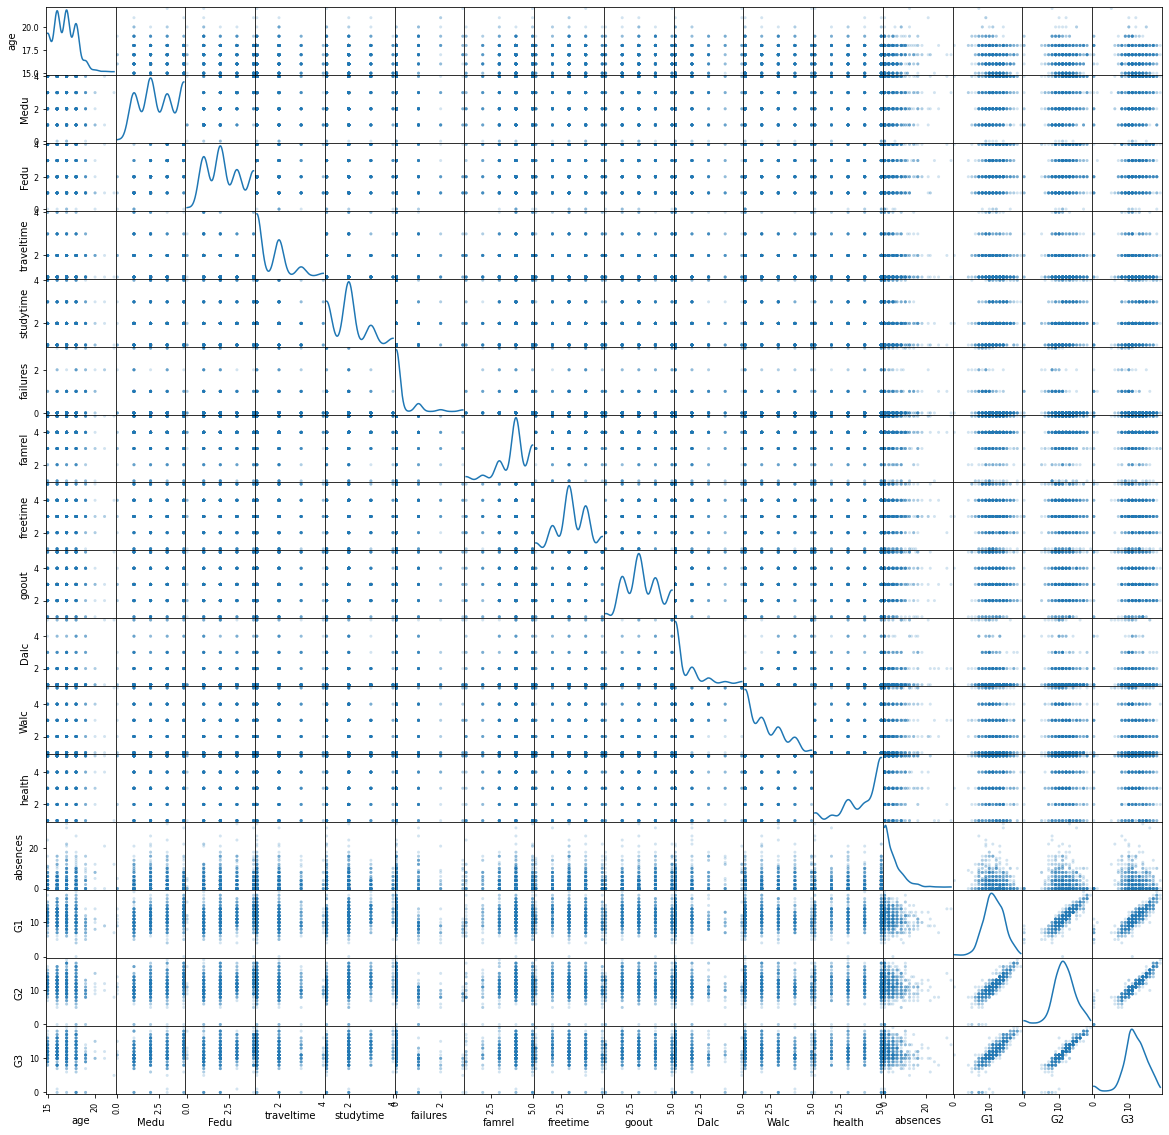

In [2]:
#Leser og viser dataene
df_tmp = pd.read_csv("../Data/student-por.csv")
print(df_tmp.head())
print(f"Antall elever = {df_tmp.shape[0]}")
print(f"Antall variabler = {df_tmp.shape[1]}")

#Plot
for variable in df_tmp.columns.values[0:-1]:
    df_tmp.plot(kind = "scatter", x=variable, y="G3")

scatter_matrix(df_tmp, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
plt.show()

### Forberedelse av dataene


Videre forbereder vi dataene. Vi starter med å sjekke om vi mangler noe data. Det gjør vi ikke. Deretter bruker vi "one hot encoding" på de kategoriske variablene. Vi setter "drop_first = True", for å fjerne unødvendige "dummy"-variabler; vi vil ha en så enkel modell som mulig.  Vi splitter så variablene i forklaringsvariabler X og respons Y. Responsen Y er den samme for modell 1, modell 2 og modell 3, mens forklaringsvariablene varierer for de tre modellene. Vi lager derfor tre lister med forklaringsvariabler: X1, X2 og X3. Til slutt splitter vi X-ene og Y inn i treningssett og testsett. Vi har valgt at treningssettet skal bestå av 80% av det totale datasettet. Dermed består testsettet av 20% av det totale datasettet. 

In [3]:
#Sjekker om det vi mangler noe data
df_tmp.isnull().sum()

#Bruker "one hot encoding" på de kategoriske variablene
categorical_cols=["sex", "school", "address", "Pstatus", "Mjob", "Fjob", "guardian", "famsize", "reason", "schoolsup", "famsup", "activities", "paid", "internet", "nursery", "higher", "romantic"]
df = pd.get_dummies(df_tmp, columns=categorical_cols, prefix=categorical_cols, prefix_sep="_", drop_first = True)

#Splitter forklaringsvariabler X og respons Y
X1 = df.drop(["G3", ], axis=1)
X2 = df[["G1", "G2"]]
X3 = df[["G1", "G2", "failures", "school_MS"]]
Y = df["G3"]

#Splitter treningssett og testsett
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, Y_train, Y_test = train_test_split(X1, X2, X3, Y, test_size = 0.20)


### Trening og testing

Neste steg er å trene og teste modellene. I treningen og testingen av modellene bruker vi Python-biblioteket XGBoost. XGBoost lager en skog med boostede regresjonstrær, basert på forskjellige parametere. Vi har valgt å inkludere følgende parametere: eta (læringsrate), max_depth (treets maksdybde) og three_method (algoritmen for hvordan treet splittes). Vi bruker XGboost sine innebygde funksjoner for cross-validation til å lage modeller, på treningssettet, med alle mulige kombinasjoner av parametere. Vi velger ut modellen som gir best prediksjon. Hvilken modell som gir best prediksjon, bestemmes av XGBoost sin "best_estimator"-funksjon. Til slutt bruker vi modellen på dataene i test-settet til å predikere karakterer, for så å sammenligne de predikerte karakterene med de gitte karakterene i testsettet. For å sammenligne bruker vi gjennomsnittlig kvadrert feil, MSE, og R2-score. 

Vi ser at alle modellene har maksdybde 1 og algoritme auto. Men modell 1 har læringsrate 0.15, mens modell 2 og 3 har læringsrate 0.1. Videre set vi at MSE-en (på treningssettet) og R2-scoren (på testsettet), er størst for modell 2, etterfulgt av modell 3. Dette indikerer at modell 2 er den beste modellen, at modell 3 er den nest beste modellen og at modell 1 er den dårligste modellen. Dette overrasket oss veldig, da vi hadde forventet at modellen med flest forklaringsvariabler (modell 1), skulle vært best, hvilket vi også oppnådde de første gangene vi kjørte koden. Det vi imidlertid uansett kan si utfra dette resultatet, er at tidligere eksamenskarakterer er de viktigste forklaringsvariablene for å predikere framtidige eksamenskarakterer. 

In [4]:
#Setter parametere og modell
params = {"eta": [0.01, 0.02, 0.1, 0.15, 0.2, 0.3], 
          "max_depth": [1, 2, 3, 4, 5], 
          "tree_method": ["auto", "exact", "approx", "hist"]}
xgb_model = xgb.XGBRegressor()
GsCV = GridSearchCV(xgb_model, params, verbose=0, scoring="neg_mean_squared_error", cv=5)

#Model 1
GsCV.fit(X1_train, Y_train)            #Lager modeller med forskjellige kombinasjoner av parametere
model1 = GsCV.best_estimator_          #Den beste modellen
print("Modell 1: ")
print(GsCV.best_score_)                #Negativ MSE for den beste modellen (på treningssettet)
print(GsCV.best_params_)               #Kombinasjonen av parametere i den beste modellen
prediction1 = model1.predict(X1_test)
print(r2_score(Y_test, prediction1))   #R2 for den beste modellen (på testsettet)

#Model 2
GsCV.fit(X2_train, Y_train)            #Lager modeller med forskjellige kombinasjoner av parametere
model2 = GsCV.best_estimator_          #Den beste modellen
print("Modell 2: ")
print(GsCV.best_score_)                #Negativ MSE for den beste modellen (på treningssettet)
print(GsCV.best_params_)               #Kombinasjonen av parametere i den beste modellen
prediction2 = model2.predict(X2_test)
print(r2_score(Y_test, prediction2))   #R2 for den beste modellen (på testsettet)

#Model 3
GsCV.fit(X3_train, Y_train)            #Lager modeller med forskjellige kombinasjoner av parametere
model3 = GsCV.best_estimator_          #Den beste modellen
print("Modell 3: ")
print(GsCV.best_score_)                #Negativ MSE for den beste modellen (på treningssettet)
print(GsCV.best_params_)               #Kombinasjonen av parametere i den beste modellen
prediction3 = model3.predict(X3_test)
print(r2_score(Y_test, prediction3))   #R2 for den beste modellen (på testsettet)


Modell 1: 
-1.7295937635326548
{'eta': 0.1, 'max_depth': 1, 'tree_method': 'approx'}
0.8469309585437523
Modell 2: 
-1.7195218568823722
{'eta': 0.1, 'max_depth': 1, 'tree_method': 'approx'}
0.8455304868209126
Modell 3: 
-1.7532397239281032
{'eta': 0.1, 'max_depth': 1, 'tree_method': 'approx'}
0.8471241710208364


### Plot

Til slutt plotter vi viktigheten av de forskjellige forklaringsvariablene og sammenhengen med de predikerte eksamenskarakterene.

Når det gjelder viktigheten av variablene, ser vi at G2 definitivt er viktigst. Deretter kommer G1, etterfulgt av failures og study time. Dette gir logisk mening. Også reason_other, Mjob_other, sex_M, absences, health, Walc, goout, freetime, traveltime og age, er viktige for modellens prediksjon av eksamenskarakterer. De resterende forklaringsvariablene, er derimot ikke viktige for modellens prediksjon av eksamenskarakterer.

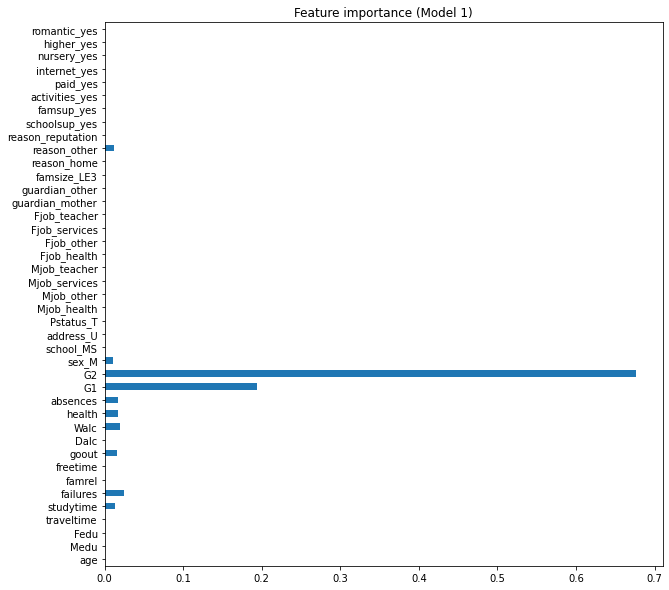

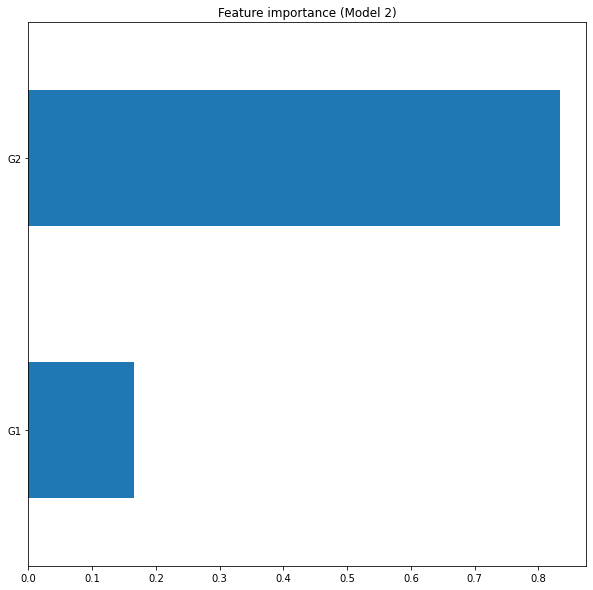

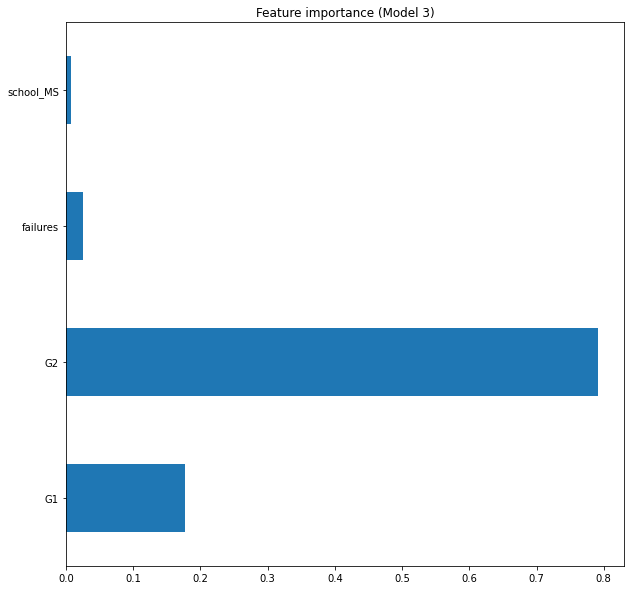

In [5]:
#Plotter viktigheten av forklaringsvariablene

#Modell 1
plt.title("Feature importance (Model 1)")
feat_importances1 = pd.Series(model1.feature_importances_, index=X1_train.columns)
feat_importances1.plot(kind='barh', figsize=(10, 10))
plt.show()
#Modell 2
plt.title("Feature importance (Model 2)")
feat_importances2 = pd.Series(model2.feature_importances_, index=X2_train.columns)
feat_importances2.plot(kind='barh', figsize=(10, 10))
plt.show()
#Modell 3
plt.title("Feature importance (Model 3)")
feat_importances3 = pd.Series(model3.feature_importances_, index=X3_train.columns)
feat_importances3.plot(kind='barh', figsize=(10, 10))
plt.show()

Partial dependence (Model 1)


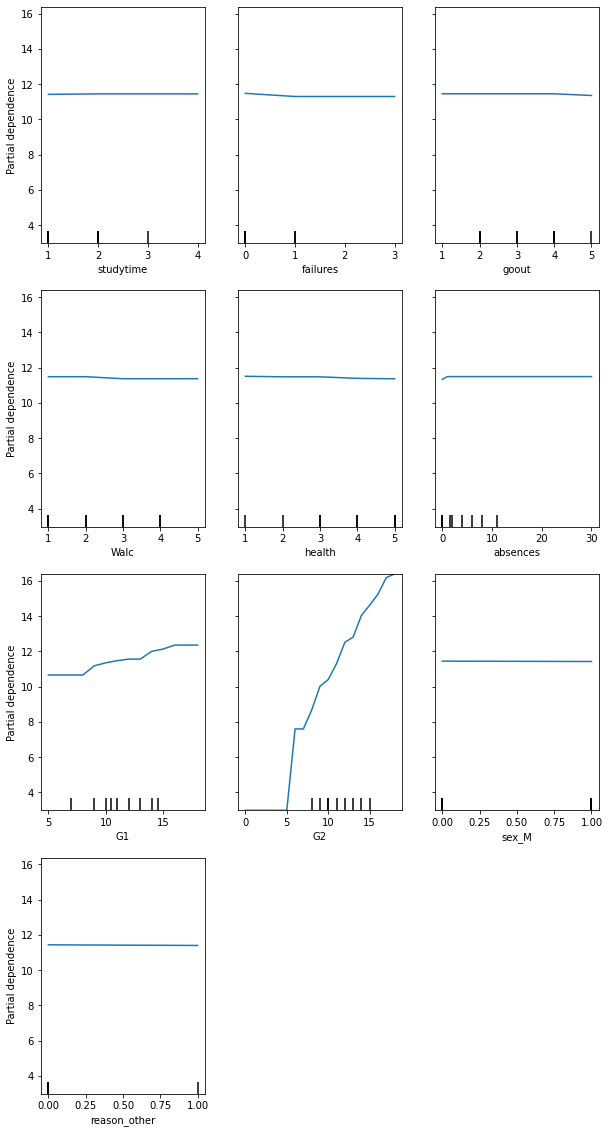

Partial dependence (Model 2)


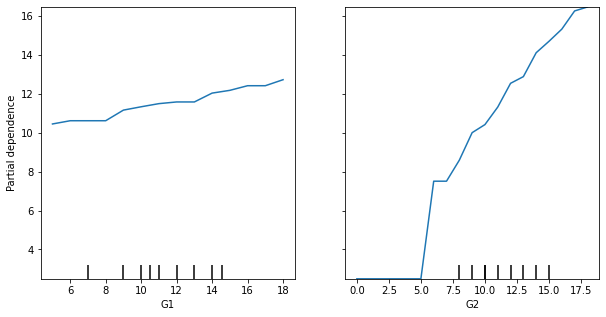

Partial dependence (Model 3)


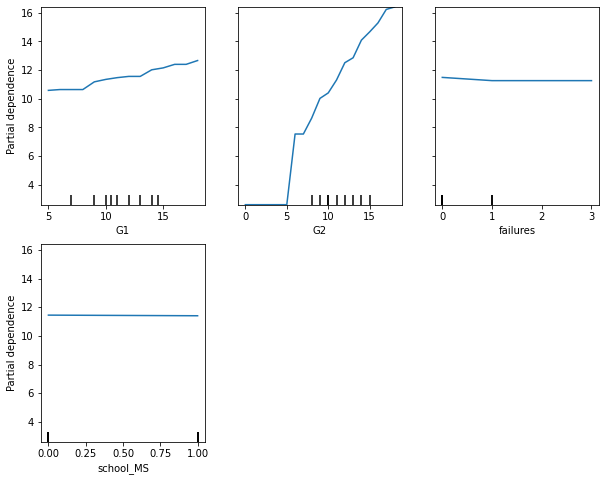

In [6]:
#Plotter avhengigheten

nonzero_indices = np.nonzero(model1.feature_importances_)

#Modell 1
print("Partial dependence (Model 1)")
fig, ax = plt.subplots(figsize=(10, 20))
plot_partial_dependence(model1, X1_test, X1_test.columns.values[nonzero_indices], ax=ax)
plt.show()

#Modell 2
print("Partial dependence (Model 2)")
fig, ax = plt.subplots(figsize=(10, 5))
plot_partial_dependence(model2, X2_test, X2.columns.values, ax=ax)
plt.show()


#Modell 3
print("Partial dependence (Model 3)")
fig, ax = plt.subplots(figsize=(10, 8))
plot_partial_dependence(model3, X3_test, X3_test.columns.values, ax=ax)
plt.show()
